In [1]:
from keras_facenet import FaceNet
from mtcnn.mtcnn import MTCNN

from sklearn.metrics.pairwise import cosine_similarity

from PIL import Image,ImageDraw
from PIL import ImageFilter
import cv2
import numpy as np
import matplotlib.pyplot as plt

import os
import glob
from pathlib import Path

folder = "Faces-Lock"
try:
    Path(folder).mkdir()
except:
    print('folder already exists')

folder already exists


In [2]:
def visual_multifaces(head_path,names):
    # head_path = "C:/Users/Raum/Desktop/jec/code/experimental/test_tourial/Faces-Lock"
    for index, i in enumerate(os.listdir(head_path)):
        files_path = os.path.join(head_path, i)
        nplots = sorted(os.listdir(files_path), key=lambda x: int(x.split('_')[1].split('.')[0]))
        print('\t',names[index])
        for j in range(len(nplots)):
            img = cv2.resize(cv2.imread(files_path+'/'+nplots[j]),(224,224))
            image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(4,10,j+1)
            plt.imshow(image_rgb)
            plt.title(j+1)
            plt.xticks([]);plt.yticks([])
        plt.show()

In [25]:
def clear_faces():
    '''for delete file in image_lock'''
    if os.listdir(folder+'/') !=[]:
        for i in os.listdir(folder+'/'): 
            folder_folder = os.path.join(folder+'/',i)
            for i in os.listdir(folder_folder+'/'):
                os.remove(os.path.join(folder_folder+'/',i))
            os.rmdir(folder_folder)

In [103]:
def detect_all(file_name): # take embeddings, and position
  embedder = FaceNet()
  detector = MTCNN()
  names = []
  images = []
  file_names = glob.glob(file_name)
  embedding_faces = {}
  data_position = {}
  crop_face = {}
  Post = 0
  for i,image in enumerate(file_names):
    NAME = os.path.splitext(os.path.basename(image))[0]
    image = Image.open(image).convert('RGB')
    im_arr = np.array(image)
    faces = detector.detect_faces(im_arr,)
    if faces !=[]:
      names.append(NAME)
      images.append(im_arr)
      datafaces = []
      position_crop =  []
      for j in faces:
        x1,y1,width,height = j['box']
        x2,y2 = (x1+width),(y1+height)
        datafaces.append([x1,y1,x2,y2])
        position_crop.append([y1,y2,x1,x2])
      data_position[NAME] = datafaces
      crop_face[Post] = position_crop # for embedding
      Post +=1
      datafaces = []
      position_crop = []

    clear_faces()  


  for i,img in enumerate(images):
      new_folder = folder+"/Faces_{}".format(names[i])
      try:
          os.makedirs(new_folder)
      except:
          print('folder already exists')
      index_image = 0
      EMBED = []
      for j in crop_face[i]:
        face = img[j[0]:j[1],j[2]:j[3]]
        pass
        image_face = Image.fromarray(face)
        image_face = image_face.resize((224,224))

        faces_crops = np.array(image_face).reshape(-1,224,224,3)
        EMBED.append(embedder.embeddings(faces_crops))

        index_image +=1
        path = new_folder+'/Face_{}.jpg'.format(index_image) # path for collect images
        image_face.save(path)
      embedding_faces[names[i]] = EMBED

  # visual_multifaces(folder,names)
  return embedding_faces,data_position,names,images

In [118]:
def plot_result(file_image,embedding_faces,position,names,FACE_LOCK=None,file_filters=None):
  if file_filters is None:
    file_filters =[None for i in range(len(names))]
    
  IMAGE_PROCESS = {}
  for i,image in enumerate(file_image):

    image = Image.fromarray(image).convert('RGB')
    if file_filters[i]:
      fitter_image = Image.open(file_filters[i]).convert('RGBA')

    Detection_check = np.zeros((len(position[names[i]])))
    if FACE_LOCK : 
      for index_face in FACE_LOCK[names[i]]:
        # print(names[i],index_face)
        for j in range(len(position[names[i]])):

          similar = cosine_similarity(embedding_faces[names[i]][index_face],embedding_faces[names[i]][j])
          if similar>0.9 and Detection_check[j] ==0 :
              Detection_check[j] = 1
              break


    for j in range(len(position[names[i]])):
        if Detection_check[j] == 1:
          continue
        else :
          x = int((position[names[i]][j][2]-position[names[i]][j][0]))
          y = int((position[names[i]][j][3]-position[names[i]][j][1]))
          if file_filters[i] is None: # censored
            censor_region = (position[names[i]][j][0],position[names[i]][j][1], position[names[i]][j][2],position[names[i]][j][3])  # Format: (left, top, right, bottom)
            censored_area = image.crop(censor_region)
            
            censored_width, censored_height = censored_area.size
            censored_area = censored_area.resize(
                (6, 6),
                Image.NEAREST
            ).resize(
                (censored_width, censored_height),
                Image.NEAREST
            )
            image.paste(censored_area, censor_region)
          else: # fitter
            fitter_face = fitter_image.resize((x,y))
            image.paste(fitter_face,(position[names[i]][j][0], position[names[i]][j][1]),fitter_face) # gan:X, gan:Y
    IMAGE_PROCESS[names[i]] = image
    
  return IMAGE_PROCESS


In [6]:
def save_images(images):
    folder = "Save_process_images"
    try:
        Path(folder).mkdir()
    except:
        print('folder already exists')
    for i in images:
        images[i].save(folder+'/'+i+'.jpg')



In [81]:
def clear_result():
    folder = 'Save_process_images'
    try:    
        for i in os.listdir(folder+'/'): 
            file = os.path.join(folder+'/',i)
            os.remove(file)
        os.rmdir(folder)
    except:
        pass

In [110]:
embedding_faces,position,names,images=detect_all(r"C:\Users\Raum\Desktop\รูปเที่ยว\*") # lock by self-image
FACE_LOCK = {NAME:[0] for NAME in names}
Filter =[r"C:\Users\Raum\Desktop\jec\code\dataface\memewoman.png" for i in range(len(names))]

Filter[0] = None
Filter[1] = None
Filter[11] = None
Filter[2] = None
Filter[4] = None
ii = plot_result(images,embedding_faces,position,names,FACE_LOCK=FACE_LOCK,file_filters=Filter)

In [113]:
# save_images(ii)
# clear_result()

In [122]:
embedding_faces,position,names,images=detect_all(r"C:\Users\Raum\Desktop\immm\*") # lock by self-image
FACE_LOCK = {NAME:[1,0,0] for NAME in names}
Filter =[None for i in range(len(names))]

ii = plot_result(images,embedding_faces,position,names,FACE_LOCK=FACE_LOCK,file_filters=Filter)
# ii = plot_result(images,embedding_faces,position,names,FACE_LOCK=FACE_LOCK,file_filters=None)

In [124]:
# save_images(ii)
# clear_result()

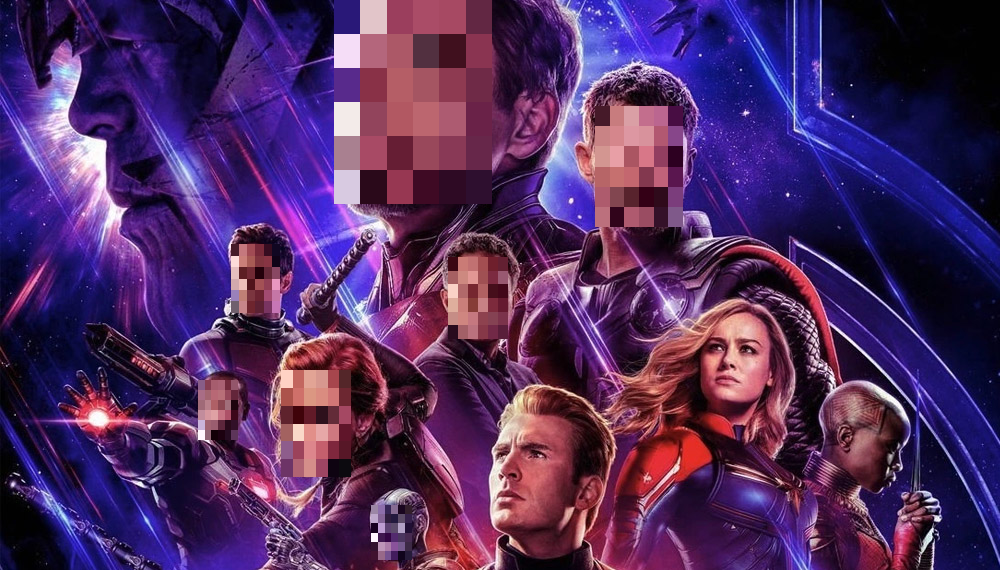

In [127]:
ii['avenger']